# Part Detection from Articulation

Ideas:
- Increase feature scale to get better context
- Instead of best match, use top-k matches for each keypoint
- Try local homography finding with ransac using sets of nearby features, not the whole image
- Nested scales: search at larger scale, then do matching of smaller scale keypoints that fit in the larger one. Could use an image pyramid for this maybe?

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cv2
from PIL import Image
from pathlib import Path
import copy
from scipy.spatial.distance import cdist
import numba
from sklearn.cluster import MiniBatchKMeans
from scipy import ndimage as ndi
import skimage.feature as skf
import skimage.transform as skt
import skimage.measure as measure
from skimage.segmentation import watershed
from skimage.color import rgb2gray
from sklearn.neighbors import KDTree
from matplotlib.patches import Ellipse
import time

In [3]:
rcParams['figure.figsize'] = (20,15)
np.set_printoptions(precision=5, linewidth=120)

In [4]:
def resize(img, s=512):
    w, h = img.size
    f = s / max(w,h)
    w, h = int(w*f), int(h*f)
    img = img.resize((w, h), 2)
    return img

In [5]:
data_path = '/multiview/datasets/papillon/images_by_pose/'
species = [
    'Danaus_plexippus',
    'Papilio_glaucus',
    'Neonympha_helicta',
    'Doxocopa_laure',
    'Smyrna_blomfildia',
    'Limenitis_archippus',
    'Limenitis_weidemeyerii',
    'Junonia_coenia',
    'Polygonia_satyrus'
]
images = list(Path(data_path).joinpath(species[0]).joinpath('dorsal_full').glob('*'))

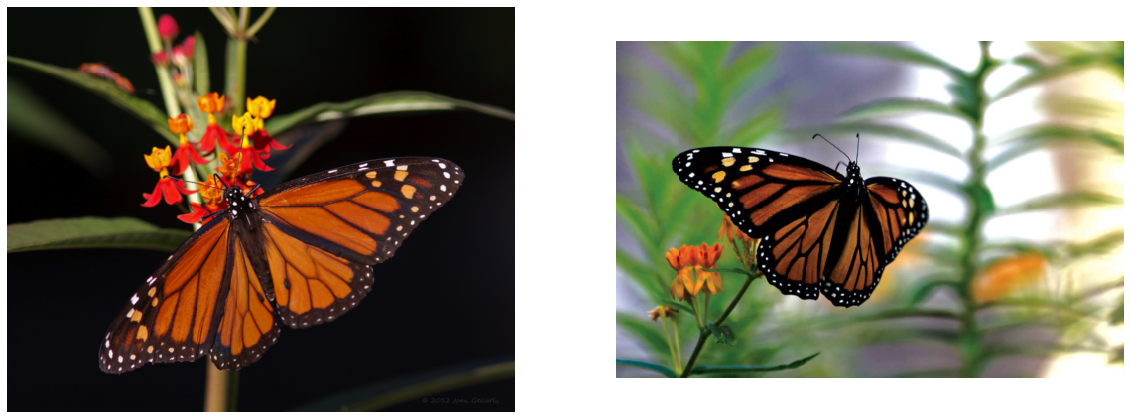

In [164]:
size = 512
image1 = resize(Image.open(images[2]), size)
img1 = array(image1)
image2 = resize(Image.open(images[12]), size)
img2 = array(image2)

fig, ax = subplots(1, 2)
for a in ax: a.axis('off')
ax[0].imshow(img1)
ax[1].imshow(img2)

In [10]:
gray = img1.mean(2)

In [48]:
%timeit cv2.GaussianBlur(grey, ksize=(0,0), sigmaX=2**(2/3), sigmaY=0)
%timeit ndi.gaussian_filter(grey, 2**(2/3))

1.81 ms ± 32.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.83 ms ± 49.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%timeit rgb2gray(img1)
%timeit cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

681 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
39.6 µs ± 127 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [36]:
%timeit skf.hessian_matrix(gray, sigma=0.75, order='xy')
%timeit hessian_matrix(gray)

5.12 ms ± 642 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.88 ms ± 90.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [63]:
from skimage.draw import random_shapes
shapes = ~random_shapes((500,500), 20, 20, 50, 200, multichannel=False, intensity_range=(1,1), allow_overlap=True)[0]

In [100]:
contours = cv2.findContours(shapes, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[0]
ellip = cv2.fitEllipseAMS(contours[0])
ellip

((78.9429931640625, 450.60595703125),
 (42.6654052734375, 46.09123611450195),
 90.91848754882812)

In [103]:
cv2.moments(contours[0])

{'m00': 1269.0,
 'm10': 100170.0,
 'm01': 572679.0,
 'm20': 8060296.5,
 'm11': 45205227.0,
 'm02': 258597409.5,
 'm30': 660447729.0,
 'm21': 3638464689.9333334,
 'm12': 20412816615.0,
 'm03': 116841253866.3,
 'mu20': 153260.32978723384,
 'mu11': 139.9787233993411,
 'mu02': 156718.37234038115,
 'mu30': 3225.5527387857437,
 'mu21': 962260.7284908146,
 'mu12': 1141.8985984139144,
 'mu03': -987675.5105133057,
 'nu20': 0.09517141174384741,
 'nu11': 8.692381608803314e-05,
 'nu02': 0.09731878277006284,
 'nu30': 5.6227670596215915e-05,
 'nu21': 0.016774079871229856,
 'nu12': 1.9905518044658796e-05,
 'nu03': -0.017217109053376548}

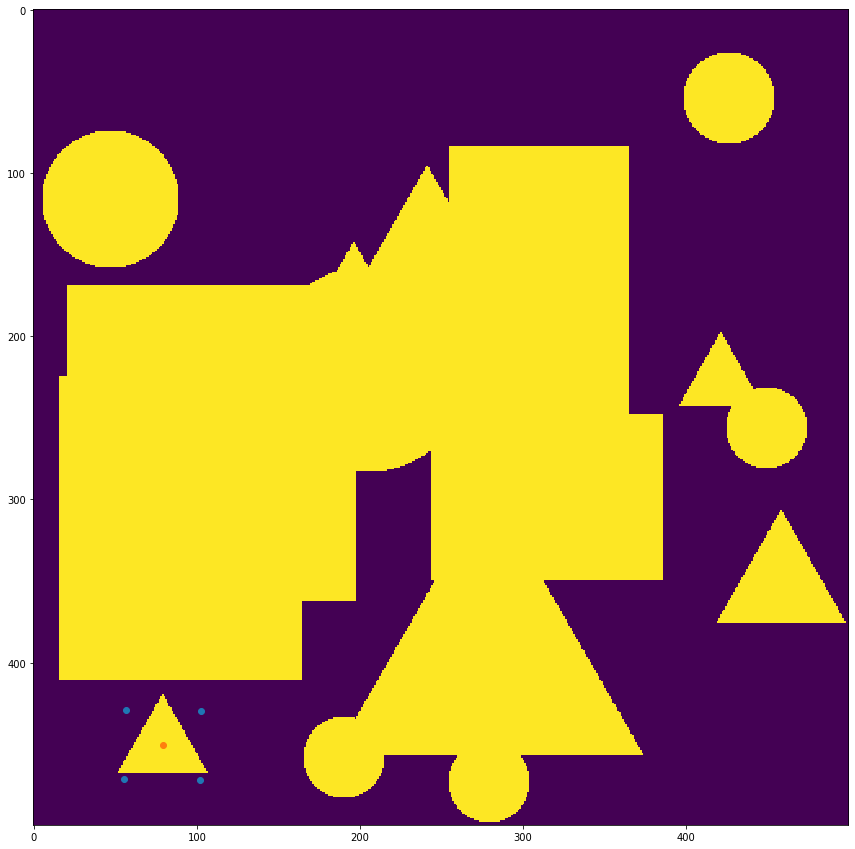

In [101]:
imshow(shapes)
# scatter(*contours[0].squeeze().T)
scatter(*array(cv2.boxPoints(ellip)).T)
scatter(*ellip[0])

# Principal Curvature Features

In [232]:
from numba import types

@numba.njit#((types.float64[:,:,:](types.float64[:,:])))
def first_gradients(src):
    h, w = src.shape[:2]
    h1, w1 = h-1, w-1
    
    grad = np.empty((*src.shape, 2))
    
    # COMPUTE THE HORIZONTAL AND VERTICAL FIRST-ORDER DERIVATIVES
    # upper left corner
    grad[0, 0, 0] = src[1,0] - src[0,0]
    grad[0, 0, 1] = src[0,1] - src[0,0]
    # first row
    for j in range(1, w1):
        grad[0, j, 1] = 0.5 * (src[0,j+1] - src[0,j-1])
        grad[0, j, 0] = src[1,j] - src[0, j]
    # upper right corner
    grad[0, w1, 0] = src[1,w1] - src[0,w1]
    grad[0, w1, 1] = src[0,w1] - src[0,w1-1]
    
    # interior
    for i in range(1, h-1):
        # first column
        grad[i, 0, 0] = 0.5 * (src[i+1,0] - src[i-1,0])
        grad[i, 0, 1] = src[i,1] - src[i,0]
        for j in range(1, w-1):
            grad[i, j, 0] = 0.5 * (src[i+1,j] - src[i-1,j])
            grad[i, j, 1] = 0.5 * (src[i,j+1] - src[i,j-1])
        # last column
        grad[i, w1, 0] = 0.5 * (src[i+1,w1] - src[i-1,w1])
        grad[i, w1, 1] = src[i,w1] - src[i,w1-1]
    
    # lower left corner
    grad[h1, 0, 0] = src[h1,0] - src[h1-1,0]
    grad[h1, 0, 1] = src[h1,1] - src[h1,0]
    # last row
    for j in range(1, w-1):
        grad[h1, j, 0] = src[h1,j] - src[h1-1,j]
        grad[h1, j, 1] = 0.5 * (src[h1,j+1] - src[h1,j-1])
    # lower right corner
    grad[h1, w1, 0] = src[h1,w1] - src[h1-1,w1]
    grad[h1, w1, 1] = src[h1,w1] - src[h1,w1-1]
    
    return grad

@numba.njit
def second_gradients(src):
    h, w = src.shape[:2]
    h1, w1 = h-1, w-1
    
    grad = first_gradients(src)
    grad2 = np.empty((*src.shape, 3))
    
    # COMPUTE THE HORIZONTAL, VERTICAL, AND DIAGONAL SECOND-ORDER DERIVATIVES
    # [row_grad(row), row_grad(col), col_grad(col)]
    # upper left corner
    grad2[0, 0, 0] = grad[1,0,0] - grad[0,0,0]
    grad2[0, 0, 1] = grad[1,0,1] - grad[0,0,1]
    grad2[0, 0, 2] = grad[0,1,1] - grad[0,0,1]
    # first row
    for j in range(1, w1):
        grad2[0, j, 0] = grad[1,j,0] - grad[0,j,0]
        grad2[0, j, 1] = grad[1,j,1] - grad[0,j,1]
        grad2[0, j, 2] = 0.5 * (grad[0,j+1,1] - grad[0,j-1,1])
    # upper right corner
    grad2[0, w1, 0] = grad[1,w1,0] - grad[0,w1,0]
    grad2[0, w1, 1] = grad[1,w1,1] - grad[0,w1,1]
    grad2[0, w1, 2] = grad[0,w1,1] - grad[0,w1-1,1]
    
    # interior
    for i in range(1, h-1):
        # first column
        grad2[i, 0, 0] = 0.5 * (grad[i+1,0,0] - grad[i-1,0,0])
        grad2[i, 0, 1] = 0.5 * (grad[i+1,1,1] - grad[i-1,1,1])
        grad2[i, 0, 2] = grad[i,1,1] - grad[i,0,1]
        for j in range(1, w-1):
            grad2[i, j, 0] = 0.5 * (grad[i+1,j,0] - grad[i-1,j,0])
            grad2[i, j, 1] = 0.5 * (grad[i+1,j,1] - grad[i-1,j,1])
            grad2[i, j, 2] = 0.5 * (grad[i,j+1,1] - grad[i,j-1,1])
        # last column
        grad2[i, w1, 0] = 0.5 * (grad[i+1,w1,0] - grad[i-1,w1,0])
        grad2[i, w1, 1] = 0.5 * (grad[i+1,w1,1] - grad[i-1,w1,1])
        grad2[i, w1, 2] = grad[i,w1,1] - grad[i,w1-1,1]
        
    # lower left corner
    grad2[h1, 0, 0] = grad[h1,0,0] - grad[h1-1,0,0]
    grad2[h1, 0, 1] = grad[h1,0,1] - grad[h1-1,0,1]
    grad2[h1, 0, 2] = grad[h1,1,1] - grad[h1,0,1]
    # last row
    for j in range(1, w-1):
        grad2[h1, j, 0] = grad[h1,j,0] - grad[h1-1,j,0]
        grad2[h1, j, 1] = grad[h1,j,1] - grad[h1-1,j,1]
        grad2[h1, j, 2] = 0.5 * (grad[h1,j+1,1] - grad[h1,j-1,1])
    # lower right corner
    grad2[h1, w1, 0] = grad[h1,w1,0] - grad[h1-1,w1,0]
    grad2[h1, w1, 1] = grad[h1,w1,1] - grad[h1-1,w1,1]
    grad2[h1, w1, 2] = grad[h1,w1,1] - grad[h1,w1-1,1]
    
    return grad2

def hessian_matrix(img):
    img = cv2.GaussianBlur(img, (0,0), sigmaX=0.75, sigmaY=0.75)
    return second_gradients(img)

@numba.njit
def calc_eigen(hess):
    out = np.empty((2, hess.shape[0], hess.shape[1]))
    a, b, c = hess[:,:,0], hess[:,:,1], hess[:,:,2]
    for i in range(hess.shape[0]):
        for j in range(hess.shape[1]):
            out[0, i, j] = (a[i,j] + c[i,j]) / 2 + np.sqrt(b[i,j]**2 + 0.25*(a[i,j] - c[i,j])**2)
            out[1, i, j] = arctan2(out[0, i, j] - a[i,j], b[i,j])
    return out

def principle_curvature(img):
    hess = hessian_matrix(img)
    return calc_eigen(hess)

@numba.njit
def select_max(octave, maxes):
    for i in range(4):
        for r in range(octave.shape[2]):
            for c in range(octave.shape[3]):
                k = octave[i:i+3, 0, r, c].argmax()
                maxes[i, :, r, c] = octave[k, :, r, c]
    return maxes
    
def gauss_scale_space(img):
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    k = 2**(1/3)
    n = int(np.floor(np.log2(min(img.shape[:2])))-3)
    
    # create gaussian pyramid
    octaves = np.empty(n, dtype=object)
    octave = np.empty((6, *img.shape))
    octave[0] = img
    ii = octave[0]
    for i in range(n):
        for j in range(1, 6):
            ii = cv2.GaussianBlur(ii, ksize=None, sigmaX=k, sigmaY=k, dst=octave[j])
        octaves[i] = octave
        if i < n-1:
            ii = cv2.resize(octave[3], None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
            octave = np.empty((6, *ii.shape))
            octave[0] = ii
    
    return octaves

def curvature_scale_space(octaves):
    n = len(octaves)
    # create principle curvature pyramid
    curvatures = np.empty(n, dtype=object)
    for i in range(len(octaves)):
        octave = np.empty((6, 2, *octaves[i][0].shape))
        for j in range(6):
            p = principle_curvature(octaves[i][j])
            octave[j] = p
        curvatures[i] = octave

    # filter by maximum of adjacent curvature images
    mpoctaves = []
    for i in range(len(curvatures)):
        imgs = curvatures[i]
        octave = np.empty((4, *imgs[0].shape))
        octave = select_max(imgs, octave)
        mpoctaves.append(octave)
        
    return mpoctaves

def morpho_close(octaves):
    struct = np.ones((5,5), dtype=np.uint8)
    struct[[0,0,4,4],[0,4,0,4]] = 0
    for i in range(len(octaves)):
        octave = octaves[i]
        for j in range(len(octave)):
            octave[j, 0] = ndi.morphology.grey_closing(octave[j, 0], footprint=struct)
        octaves[i] = octave
    return octaves

@numba.njit
def _high_low(img, mask, high, low=(.2,.7), ave_thresh=0.75):
    stk = []
    # start by labeling as either high (1) or low (2)
    for i in range(1, img.shape[1]-1):
        for j in range(1, img.shape[2]-1):
            if img[0, i, j] > high:
                mask[i, j] = 1
                stk.append([i, j])
            else:
                p = img[1, i, j]
                ave = (np.abs(np.cos(img[1, i-1, j-1:j+2] - p)).sum() +
                       np.abs(np.cos(img[1, i, j-1] - p)) +
                       np.abs(np.cos(img[1, i, j+1] - p)) +
                       np.abs(np.cos(img[1, i+1, j-1:j+2] - p)).sum()) / 8.0
                t = high * (low[0] if ave > ave_thresh else low[1])
                mask[i, j] = 2 if img[0, i, j] > t else 0
    return stk

@numba.njit
def threshold(img, mask, high=0.04, low=(.2,.7), ave_thresh=0.75):
    # img (2, H, W) and mask (H, W)
    
    # start by labeling as either high (1) or low (2)
    stk = _high_low(img, mask, high, low, ave_thresh)
    
    # relable based on connectivity
    neighbors = [[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]]
    while len(stk) > 0:
        i, j = stk.pop()
        for k in range(len(neighbors)):
            r, c = neighbors[k]
            ii, jj = i+r, j+c
            if mask[ii, jj] == 2:
                mask[ii, jj] = 1
                stk.append([ii, jj])
                
    # clear out remaining 2s
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j] == 2: mask[i, j] = 0
    
    return mask

def threshold_eigen_hyst(octaves, high=None, low=(.2,.7), ave_thresh=0.75, quantile=None):
    use_quantile = quantile is not None
    high = 0.04 if high is None else high
    masks = []
    for octave in octaves:
        mask = np.zeros((4, *octave.shape[-2:]), dtype=np.uint8)
        for i in range(len(octave)):
            if use_quantile:
                high = np.quantile(octave[i,0].ravel(), quantile)
            threshold(octave[i], mask[i], high, low, ave_thresh)
        masks.append(mask)
    return masks

def segment(masks):
    segs = []
    for mask in masks:
        seg = np.empty(mask.shape, dtype=np.int32)
        for i in range(mask.shape[0]):
            seg[i] = watershed(mask[i])
        segs.append(seg)
    return segs

def extract_regions(segs):
    pyr = np.empty(len(segs), dtype=object)
    for s, seg in enumerate(segs):
        scale = np.empty(seg.shape[0], dtype=object)
        for i, img in enumerate(seg):
            props = measure.regionprops(img)
            rs = np.empty((len(props), 5), dtype=np.float64)
            for j, r in enumerate(props):
                rs[j, :2] = r['centroid']
                rs[j, 2] = r['orientation']
                rs[j, 3] = r['major_axis_length']
                rs[j, 4] = r['minor_axis_length']
            scale[i] = rs
        pyr[s] = scale
    return pyr

# def scale_matches(rs1, rs2):
#     # filter first by proportional area of descriptors
#     ar1 = array([x[2]*x[3] for x in rs1]) # areas of first scale
#     ar2 = array([x[2]*x[3] for x in rs2]) # areas of second scale
#     idx1 = ar1.argsort()[::-1]
#     idx2 = ar2.argsort()[::-1]
#     t = 0.7
#     potential = []
#     start = 0
#     for i in range(len(idx1)):
#         ii = idx1[i]
#         in_range = False
#         for j in range(start, len(idx2)):
#             jj = idx2[j]
#             r = ar1[ii] / (ar2[jj]+1e-6)
#             r = 1/r if r > 1 else r
#             if r > t:
#                 potential.append([ii, jj])
#                 if not in_range:
#                     in_range = True
#                     start = j
#             elif in_range:
#                 break
                
#     potential = [x for x in potential if
#                  abs(rs1[x[0]][1]-rs2[x[1]][1]) < 20*pi/180]
    
#     def distance(x1, x2):
#         delta = np.subtract(x2[0], x1[0]) # vector from centroid 1 to centroid 2
#         angle = x1[1] # angle of centroid 1
#         c = np.cos(angle)
#         s = np.sin(angle)
#         delta_p = array([[c,s],[-s,c]]) @ delta
#         delta_p = delta_p / [x1[2], x1[3]]
#         d = (delta_p**2).sum()
#         return d
    
#     potential = [x for x in potential if
#                  distance(rs1[x[0]], rs2[x[1]]) < .01]
#     return potential

def filter_consistent(regions):
    final = np.empty(len(regions), dtype=object)
    for i, octave in enumerate(regions):
        tree1 = KDTree(octave[1], leaf_size=20)
        tree2 = KDTree(octave[2], leaf_size=20)
        
        d1 = tree1.query(octave[0])[0].ravel()
        d2 = tree2.query(octave[0])[0].ravel()
        
        mask1 = 0.5 * (d1 + d2) < 0.1 # figure out the right threshold
        
        tree1 = KDTree(octave[3], leaf_size=20)
        d1 = tree1.query(octave[1])[0].ravel()
        d2 = tree2.query(octave[1])[0].ravel()
        
        mask2 = 0.5 * (d1 + d2) < 0.1
        
        final[i] = np.concatenate((octave[0][mask1], octave[1][mask2]), 0)
        
    return final

def get_mu_sig(r):
    mu = r[1::-1]
    c, s = np.cos(r[2]), np.sin(r[2])
    rot = np.array([[c,-s],[s,c]])
    L = np.eye(2) * (r[3:] / 6)**2
    sig = rot @ L @ rot.T
    return mu, sig

def mvn_kl(r1, r2):
    mu1, sig1 = get_mu_sig(r1)
    mu2, sig2 = get_mu_sig(r2)
    
    sig1inv = np.linalg.inv(sig1)
    sig2inv = np.linalg.inv(sig2)
    det1 = np.linalg.det(sig1)
    det2 = np.linalg.det(sig2)
    mu21 = mu2 - mu1
    mu12 = mu1 - mu2
    kl12 = 0.5 * (np.trace(sig2inv @ sig1) + mu21.T @ (sig2inv @ mu21) - 2 + np.log(det2/det1))
    kl21 = 0.5 * (np.trace(sig1inv @ sig2) + mu12.T @ (sig1inv @ mu12) - 2 + np.log(det1/det2))
    kl = max(0, 0.5 * (kl12 + kl21))
    return max(kl, 0)

def unify_detections(regions):
    # Rescale and flatten detections
    combined = []
    for i, level in enumerate(regions):
        s = 2**(i-1)
        dd = level.copy()
        dd[:, [0,1,3,4]] *= s
        combined.append(dd)
    combined = np.concatenate(combined, 0)
#         for d in level:
#             dd = [[d[0][0]*s, d[0][1]*s], d[1], d[2]*s, d[3]*s]
#             combined.append(dd)
            
    # remove duplicates
    locs = np.array([x[0] for x in combined])
    area = np.prod([x[2:] for x in combined], 1)
    neighbors = KDTree(locs, leaf_size=20)
    nearby = neighbors.query_radius(locs, np.sqrt(area)*.1)
    
    done = set()
    final = []
    for i in range(len(nearby)):
        if i in done: continue
        for j in nearby[i]:
            if i==j or j in done: continue
            d = mvn_kl(combined[i], combined[j])
            if d < 0.25:
                done.add(j)
        final.append(combined[i])
        done.add(i)
    return final

def principle_curvature_features(img):
    start_time = time.time()
    ss = scale_space(img1)
    ss = morpho_close(ss)
    masks = threshold_eigen_hyst(ss, low=(.15, .7), quantile=.999)
    segs = segment(masks)
    regions = extract_regions(segs)
    final = filter_consistent(regions)
    final = unify_detections(final)
    return final
    print(time.time() - start_time)

In [34]:
%load_ext snakeviz
%snakeviz -t principle_curvature_features(img1)

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz
 
*** Profile stats marshalled to file '/tmp/tmpgxpnhzp2'. 
Opening SnakeViz in a new tab...


In [112]:
def show_pyramid(pyr, width=20, cmap='gray'):
    levels = len(pyr)
    scales = pyr[0].shape[0]
    h, w = pyr[0].shape[-2:]
    ww = width
    hh = ww * (levels * h) / (scales * w)
    fig, ax = subplots(levels, scales, figsize=(ww, hh), tight_layout=True)
    for axes, p in zip(ax, pyr):
        for a, img in zip(axes, p):
            if img.ndim > 2: img = img[0]
            a.imshow(img, cmap=cmap)
            a.axis('off')
    return fig, ax

In [231]:
start_time = time.time()
ckpt = start_time

gss = gauss_scale_space(img1)
print(f'Build gaussian scale space: {time.time()-ckpt}')
ckpt = time.time()

ss = curvature_scale_space(gss)
print(f'Build curvature scale space: {time.time()-ckpt}')
ckpt = time.time()

ss = morpho_close(ss)
print(f'Morphological close: {time.time()-ckpt}')
ckpt = time.time()

masks = threshold_eigen_hyst(ss, low=(.15, .7), quantile=.999)
print(f'Eigen hysteresis threshold: {time.time()-ckpt}')
ckpt = time.time()

segs = segment(masks)
print(f'Watershed segments: {time.time()-ckpt}')
ckpt = time.time()

regions = extract_regions(segs)
print(f'Extract elliptical regions: {time.time()-ckpt}')
ckpt = time.time()

final = filter_consistent(regions)
print(f'Filter for scale consistency: {time.time()-ckpt}')
ckpt = time.time()
# print(sum([len(x) for x in final]))

final = unify_detections(final)
print(f'Remove duplicates: {time.time()-ckpt}')
ckpt = time.time()

# print(len(final))
print(f'Total time: {time.time() - start_time}')

Build gaussian scale space: 0.043494462966918945
Build curvature scale space: 0.394284725189209
Morphological close: 0.16129708290100098
Eigen hysteresis threshold: 1.1075522899627686
Watershed segments: 0.3069267272949219
Extract elliptical regions: 1.6990840435028076
Filter for scale consistency: 0.01101064682006836


IndexError: invalid index to scalar variable.

In [224]:
# final = np.empty(len(regions), dtype=object)
# for i, octave in enumerate(regions):
octave = regions[-2]
tree1 = KDTree(octave[1], leaf_size=20)
tree2 = KDTree(octave[2], leaf_size=20)

d1 = tree1.query(octave[0])[0].ravel()
d2 = tree2.query(octave[0])[0].ravel()

# mask1 = 0.5 * (d1 + d2) < 0.1 # figure out the right threshold

# tree1 = KDTree(octave[3], leaf_size=20)
# d1 = tree1.query(octave[1])[0].ravel()
# d2 = tree2.query(octave[1])[0].ravel()

# mask2 = 0.5 * (d1 + d2) < 0.1

#     final[i] = np.concatenate((octave[0][mask1], octave[1][mask2]), 0)

In [226]:
d1

array([0.53833, 1.67187, 2.97431, 0.     , 1.56216, 3.88596, 0.     , 0.     , 0.65557, 0.74143, 4.67753, 0.2005 ,
       2.28568, 3.20156, 0.     , 0.64577, 0.92699, 1.23344, 1.28641, 0.     , 1.3786 , 1.59658, 1.48587, 3.46386,
       2.30486, 1.44177, 2.20633, 4.86499, 3.6625 , 2.86944, 0.70223, 1.22622, 0.16463, 0.     , 0.2019 , 6.10991,
       0.79074, 0.90549, 0.     , 1.34689, 0.81783, 0.97016])

In [222]:
print('initial regions')
for r in regions:
    print([len(x) for x in r])
print('\nfinal regions')
print([len(x) for x in final])

initial regions
[694, 652, 660, 617]
[585, 546, 553, 544]
[390, 366, 355, 330]
[135, 129, 119, 119]
[42, 42, 40, 34]
[18, 13, 14, 12]

final regions
[188, 170, 117, 20, 13, 1]


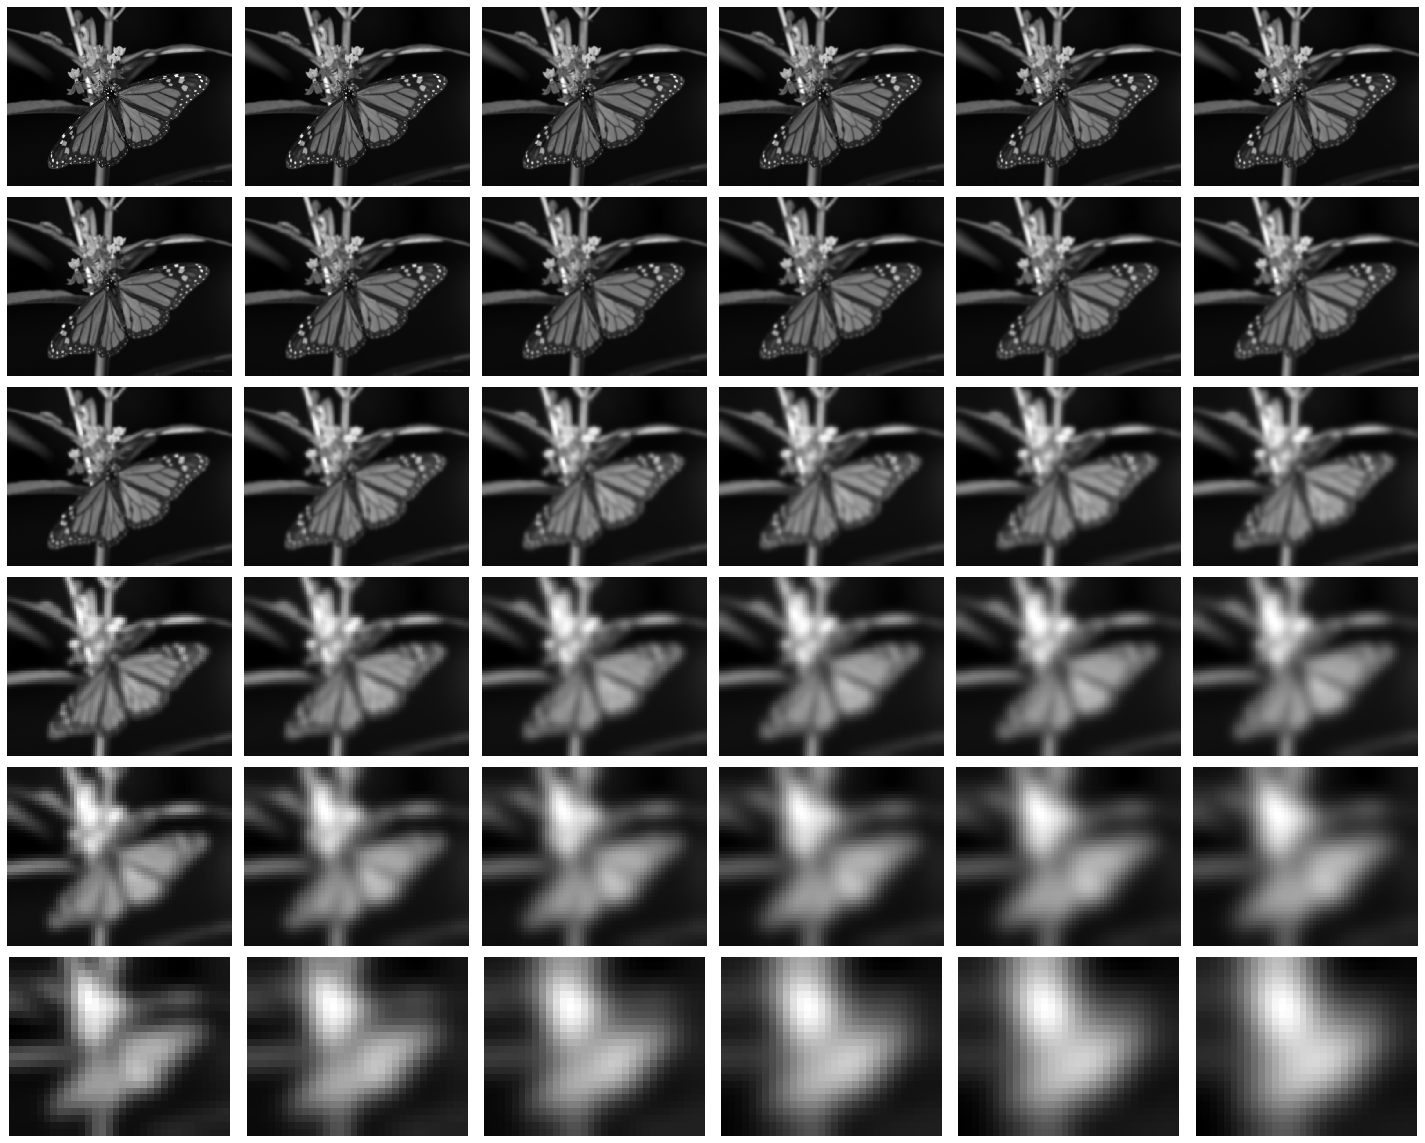

In [202]:
fig, ax = show_pyramid(gss)

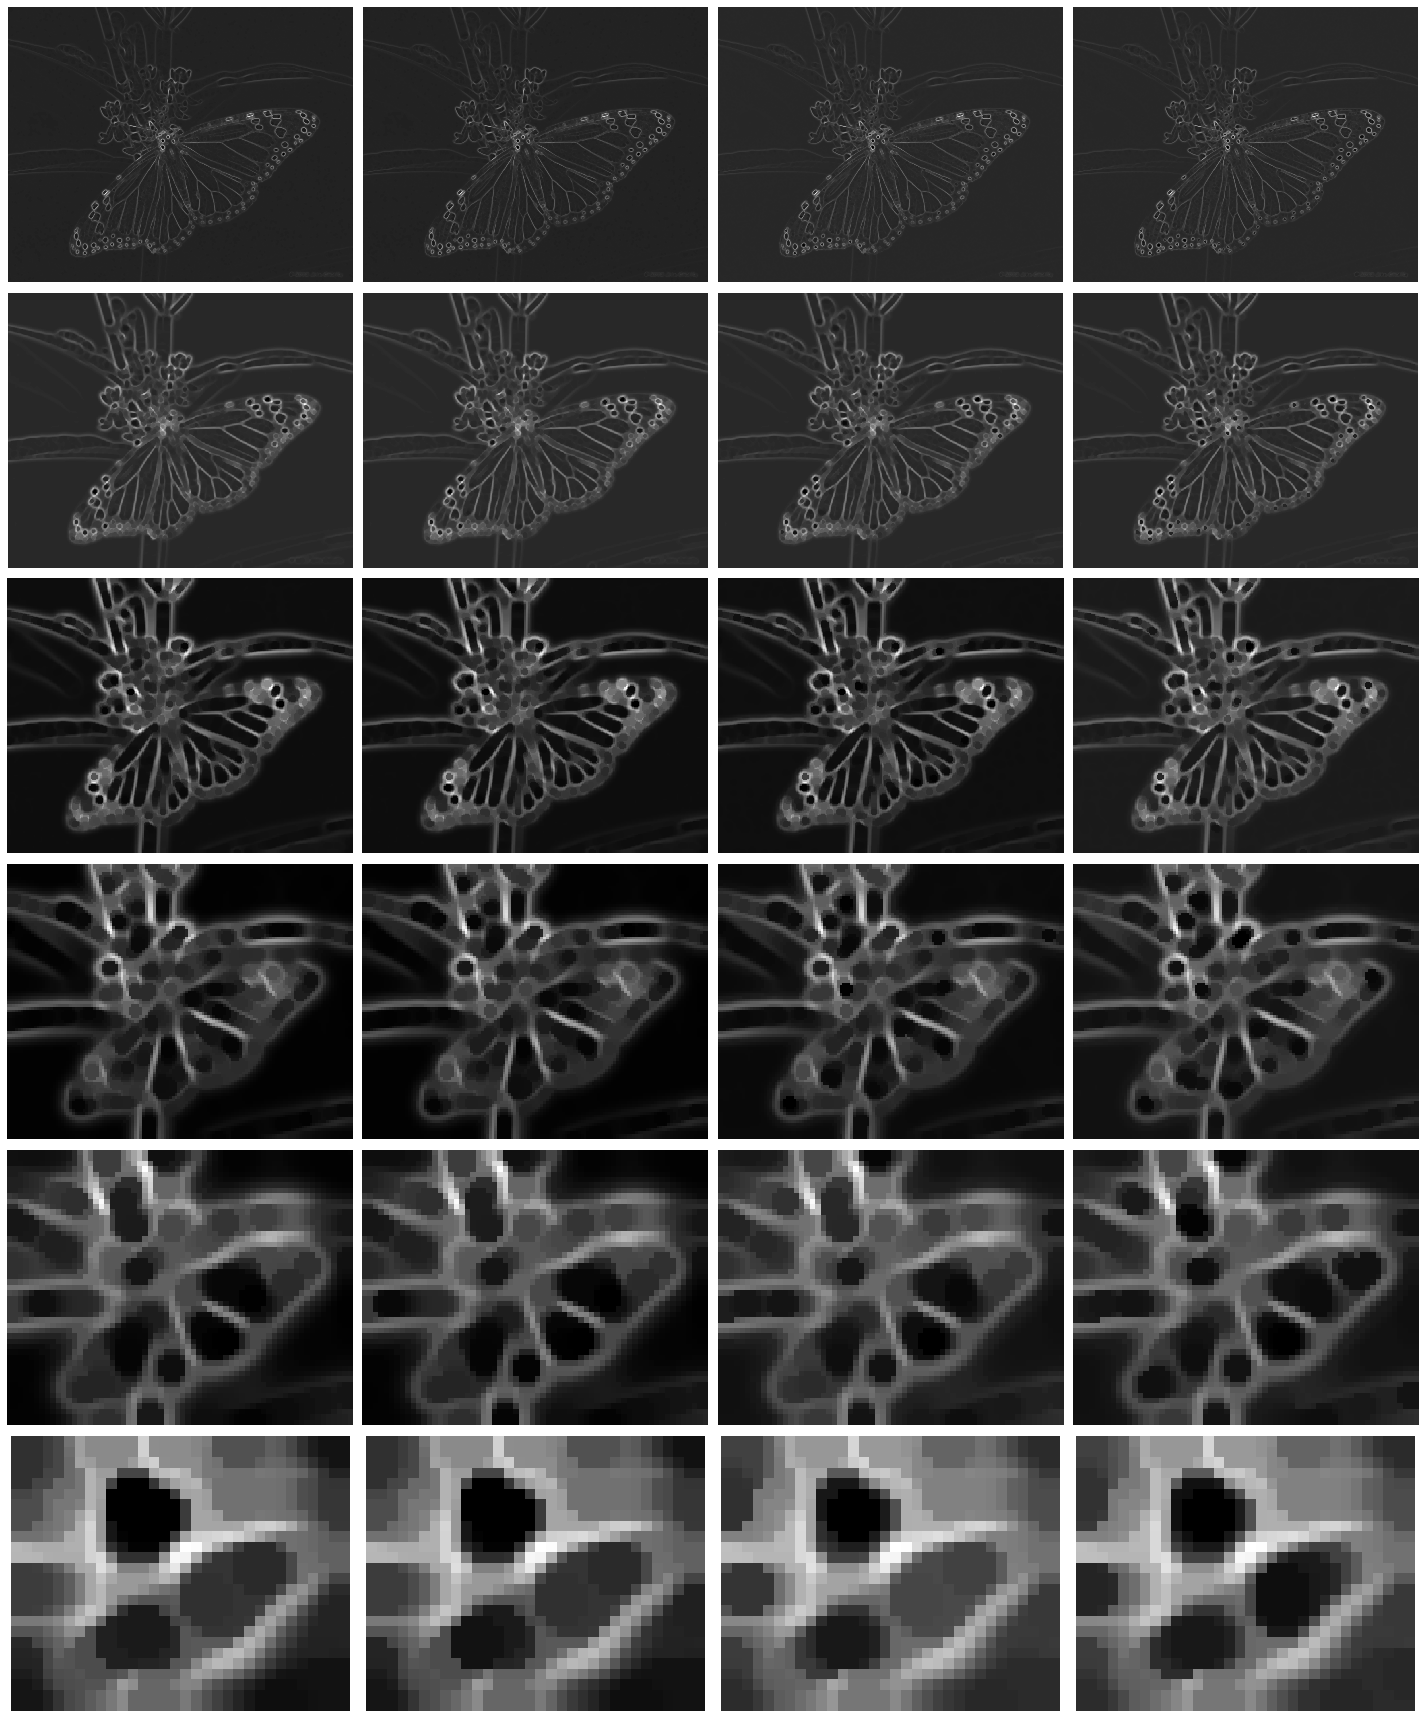

In [203]:
fig, ax = show_pyramid(ss)

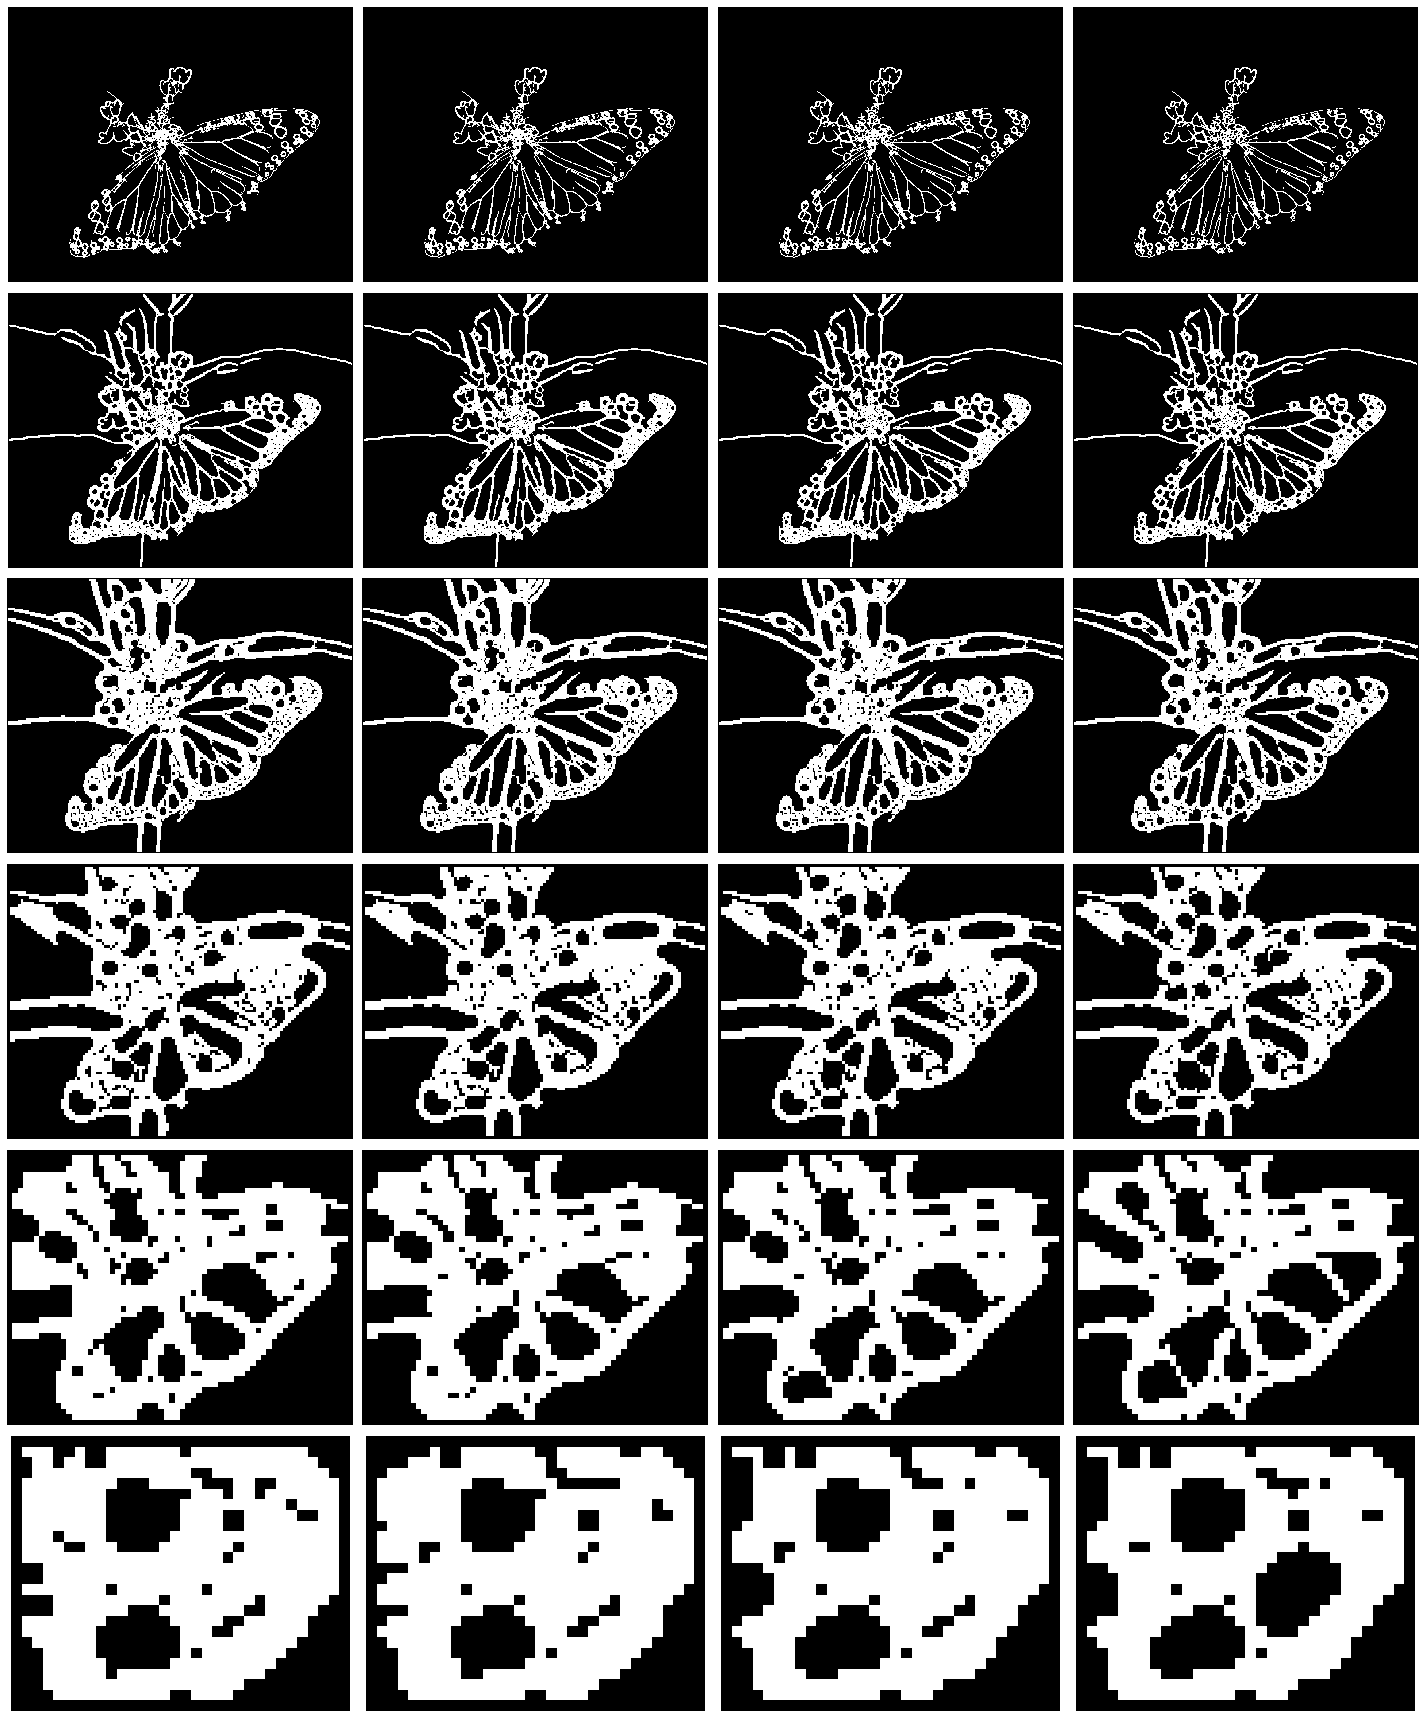

In [204]:
fig, ax = show_pyramid(masks)

7009


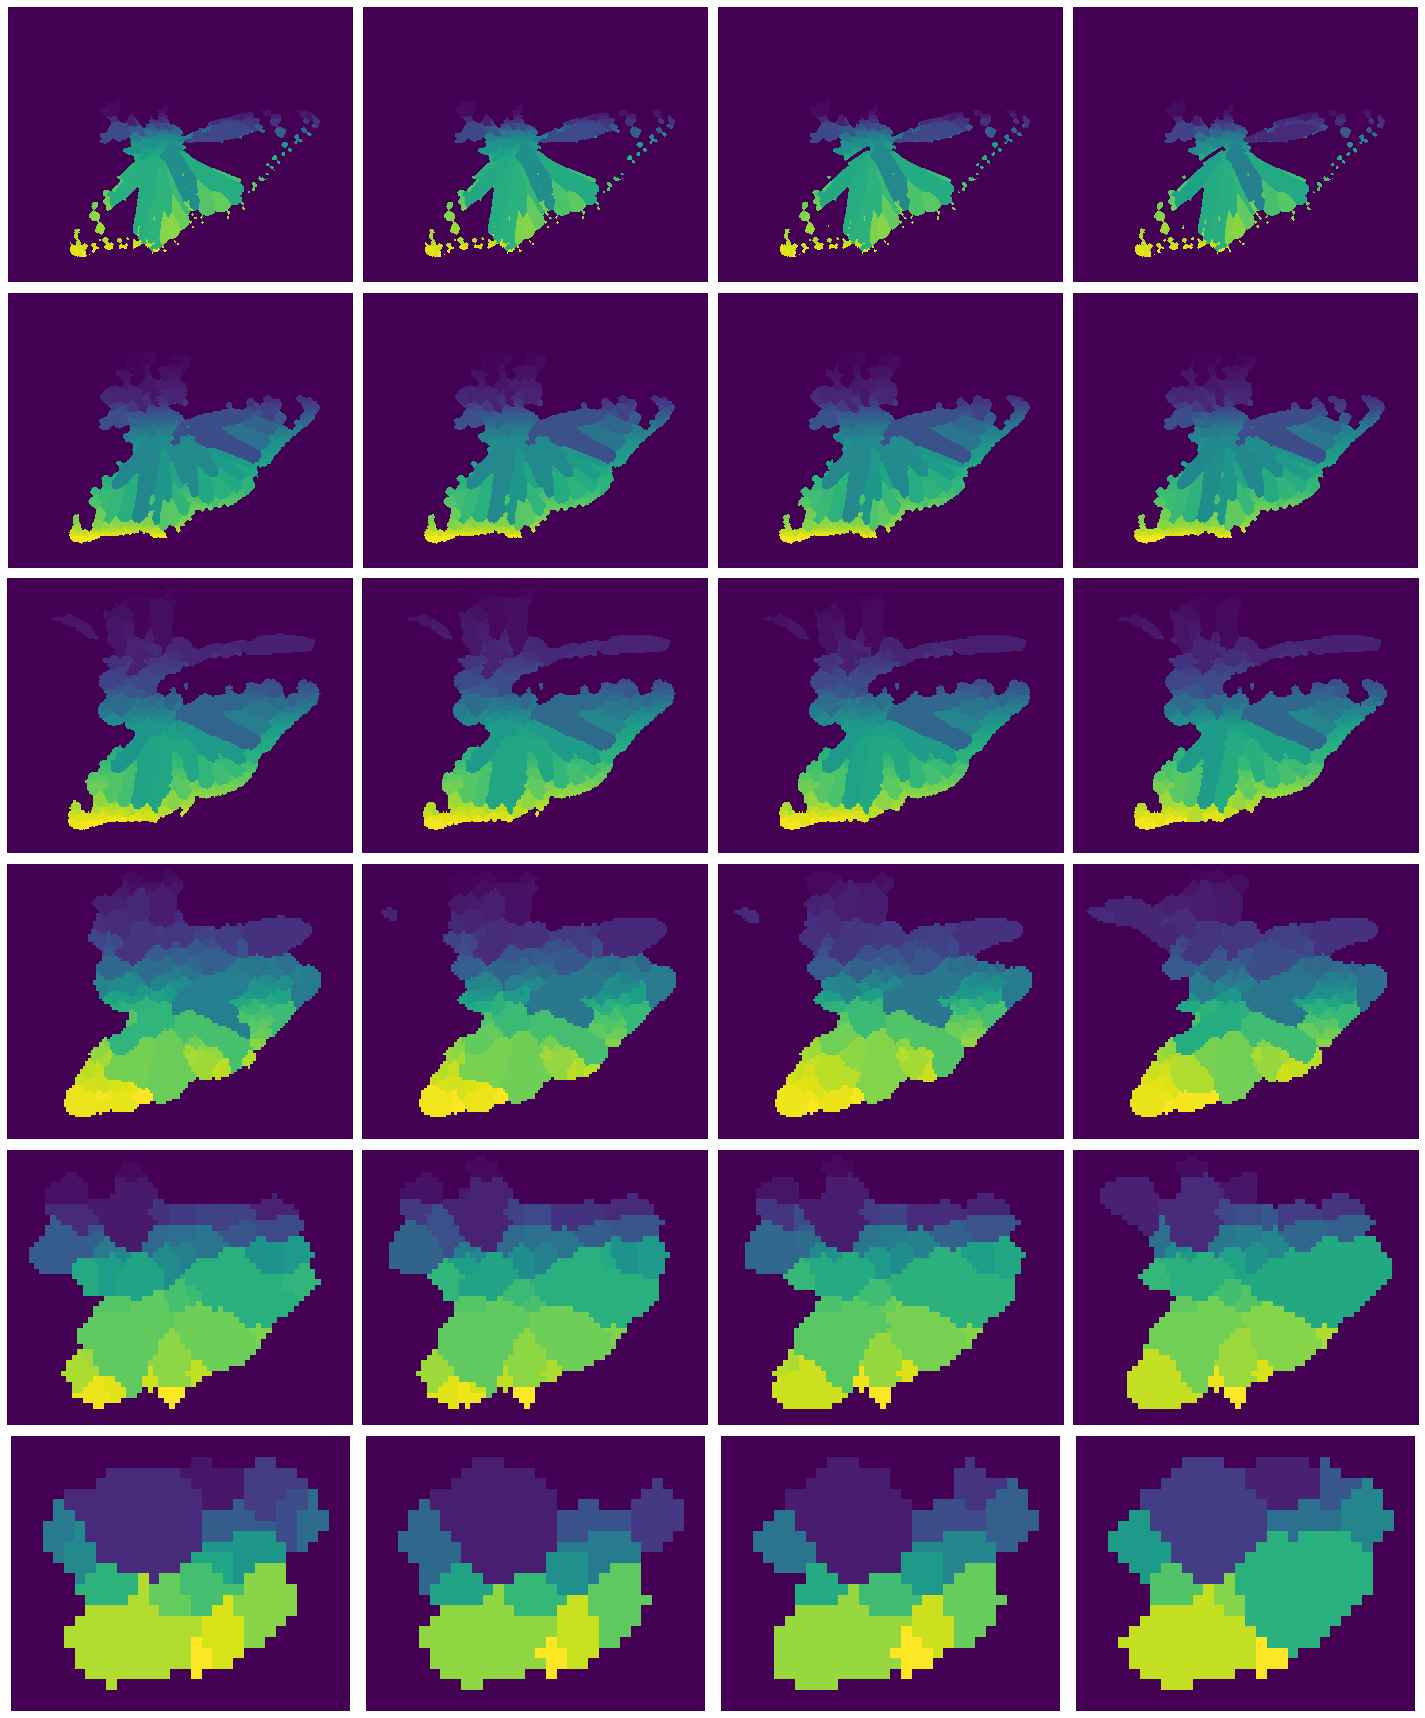

In [205]:
print(sum([len(r) for x in regions for r in x]))
fig, axes = show_pyramid(segs, cmap='viridis')
# for i in range(len(regions)):
#     for j in range(len(regions[0])):
#         for r in regions[i][j]:
#             axes[i,j].add_artist(
#                 Ellipse(r[0][::-1],
#                         r[2],
#                         r[3],
#                         -r[1]*180/pi+90,
#                         ec='red', fc=(0,0,0,0)))

In [229]:
def show_detections(img, detects, pairs=None, figsize=None):
    fig, ax = subplots(1,1, figsize=figsize)
    ax.imshow(img)
    if pairs is None:
        it = iter(detects)
    else:
        it = (detects[i] for i in set(k for p in pairs for k in p[:2]))
    for r in it:
        ax.add_artist(Ellipse(array(r[1::-1]), r[3], r[4], -r[2]*180/pi+90, ec='red', fc=(0,0,0,0)))

In [230]:
print(len(final))
show_detections(img1, final)

6


IndexError: index 3 is out of bounds for axis 0 with size 1

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f77ef44ac80> (for post_execute):


ValueError: setting an array element with a sequence.

ValueError: setting an array element with a sequence.

<Figure size 1440x1080 with 1 Axes>

In [16]:
start_time = time.time()
ss = scale_space(img2)
ss = morpho_close(ss)
masks = threshold_eigen_hyst(ss, low=(.15, .7), quantile=.999)
segs = segment(masks)
regions = extract_regions(segs)
final = filter_consistent(regions)
print(sum([len(x) for x in final]))
final = unify_detections(final)
print(len(final))
print(time.time() - start_time)

965
569
3.823029041290283


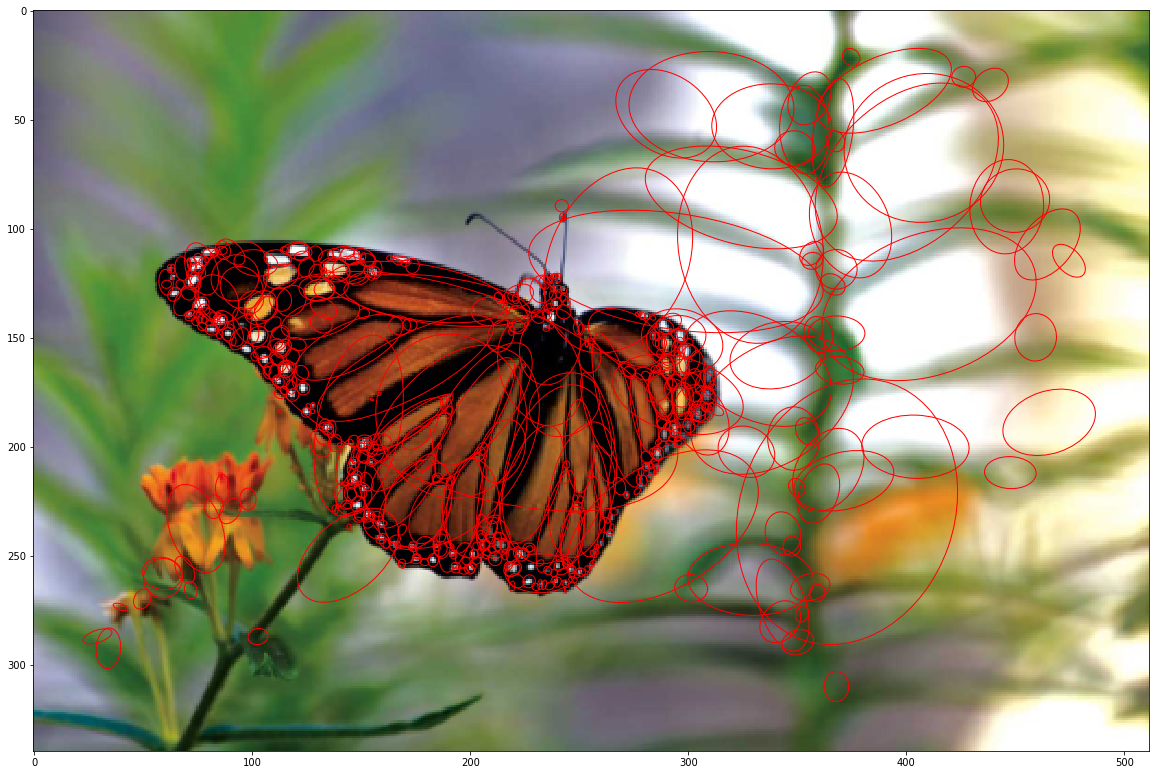

In [17]:
show_detections(img2, final)

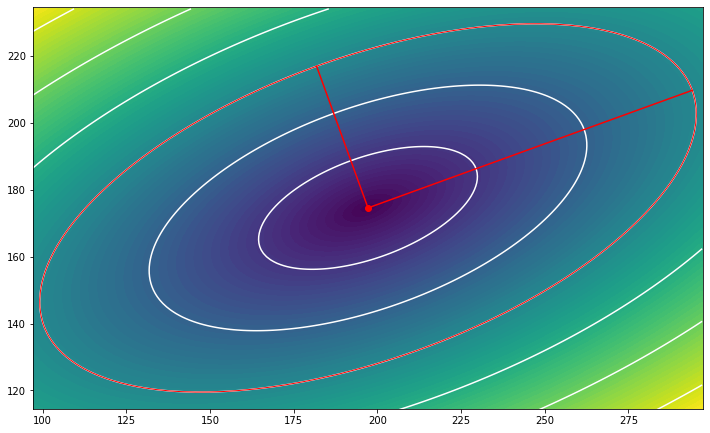

In [30]:
from scipy import stats
fig, ax = subplots(1,1, figsize=(12,12))

r = final[0]

mu = r[0][::-1]  # center (mean)
theta = -r[1] + pi/2  # rotation angle

# set up rotation matrix around theta, which is also the eigenvectors of
# the covariance matrix
c, s = np.cos(theta), np.sin(theta)
rot = array([[c,-s],[s,c]])

# set up eigenvalue matrix L. The eigenvalues are equal to the variance.
# We want the boundary to be at 3 standard deviations from the mean. So
# we take 1/3 of half the axis length as a single std dev and square to get
# variance
L = np.eye(2) * (array(r[2:]) / 6)**2
# calculate the covariance matrix from the eigenvalue/eigenvector decomposition
sig = rot @ L @ rot.T

# plot the center and the two axes
ax.scatter(*mu, c='r', zorder=100)
ax.plot(*stack([mu, mu+rot[:,0]*r[2]/2], 1), c='r')
ax.plot(*stack([mu, mu+rot[:,1]*r[3]/2], 1), c='r')

ax.set_xlim(mu[0]-100, mu[0]+100)
ax.set_ylim(mu[1]-60, mu[1]+60)
ax.set_aspect('equal')

# calculate and plot contours of the distance from the mean in standard deviations
g = stack(mgrid[int(mu[1])-60:int(mu[1])+61, int(mu[0])-100:int(mu[0])+101], 2)[...,::-1]
d = np.sqrt(((g-mu) * ((g-mu) @ inv(mvn.cov).T)).sum(-1))
contourf(g[:,:,0], g[:,:,1], d, levels=100)
contour(g[:,:,0], g[:,:,1], d, levels=range(8), colors='w')

# plot the ellipse boundary
ax.add_artist(
    Ellipse(array(r[0][::-1]), r[2], r[3], -r[1]*180/pi+90,
            ec='red', fc=(0,0,0,0), zorder=100))
pass